# Evaluating SHAP

## Imports and Setup

In [1]:
import os
import platform
from pathlib import Path

# for when on NCC to be able to import local packages
os.chdir(os.path.expanduser("~/l3_project"))
Path.cwd()

PosixPath('/home2/jgcw74/l3_project')

In [2]:
import importlib

import helpers
import dataset_processing.eurosat

# to reload local module changes without kernel restart
importlib.reload(helpers.evaluate_xai)
importlib.reload(helpers.plotting)

/home2/jgcw74/l3_project/helpers/evaluate_xai.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


<module 'helpers.plotting' from '/home2/jgcw74/l3_project/helpers/plotting.py'>

In [3]:
import copy

from captum.attr import DeepLiftShap
import shap

import numpy as np
import matplotlib.pyplot as plt
import einops

import torch
import torch.nn as nn
import torchvision.transforms.v2 as transforms

from safetensors.torch import load_model

In [4]:
print(f'Using PyTorch {torch.__version__} on {platform.system()}')

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Found {torch.cuda.get_device_name()} to use as a cuda device.')
elif platform.system() == 'Darwin':
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f'Using {device} as torch device.')

if platform.system() != 'Linux':
    torch.set_num_threads(1)  # significantly speeds up data loading processes with less loading overhead
    # see https://discuss.pytorch.org/t/pytorch-v2-high-cpu-consumption/205990 and https://discuss.pytorch.org/t/cpu-usage-far-too-high-and-training-inefficient/57228
    print('Set number of threads to 1 as using a non-Linux machine.')

Using PyTorch 2.5.1 on Linux
Found NVIDIA A100 80GB PCIe MIG 1g.10gb to use as a cuda device.
Using cuda as torch device.


In [5]:
np_rng = np.random.default_rng(42)  # for reproducibility
_ = torch.manual_seed(42)

# EuroSAT (RGB) Dataset

In [6]:
eurosat_val_ds = dataset_processing.eurosat.get_standard_rgb("val")

num_eurosat_classes = len(eurosat_val_ds.classes)

print(f"There are {len(eurosat_val_ds)} validation samples.")
print("Image dimensions and label:", eurosat_val_ds[0]["image"].size(), eurosat_val_ds[0]["label"])

There are 5400 validation samples.
Image dimensions and label: torch.Size([3, 224, 224]) tensor(0)


In [7]:
val_dataloader = torch.utils.data.DataLoader(
    eurosat_val_ds, batch_size=32, num_workers=4, shuffle=False, drop_last=False
)
validation_iterator = iter(dataset_processing.core.cycle(val_dataloader))

## ResNet 50

### Load Model

In [8]:
checkpoints_path = Path.cwd() / 'checkpoints'
assert checkpoints_path.exists()

In [9]:
all_resnet50_saved = list(checkpoints_path.glob('./resnet50/*.st'))
# print(all_resnet50_saved)
latest_resnet50_path = max(all_resnet50_saved, key=os.path.getctime)
latest_resnet50_path

PosixPath('/home2/jgcw74/l3_project/checkpoints/resnet50/FineTunedResNet50_final_ft_weights(0.989).st')

In [10]:
resnet50 = helpers.models.FineTunedResNet50(num_classes=num_eurosat_classes).to(device)

In [11]:
print('Missing/Unexpected keys:', load_model(resnet50, latest_resnet50_path))
_ = resnet50.eval()  # turn off randomisation in batchnorm layers, etc.

Missing/Unexpected keys: (set(), [])


#### Confirm model accuracy

In [12]:
check_acc = False
if check_acc:
    _, acc = helpers.ml.validation_step(
        resnet50, nn.CrossEntropyLoss(), validation_iterator, len(val_dataloader)
    )
    assert acc > 0.98
    print("Validation accuracy", acc)

### Select images to explain

In [13]:
idxs_to_explain = np_rng.integers(0, len(eurosat_val_ds), 5)
imgs_to_explain = torch.stack([eurosat_val_ds[i]["image"] for i in idxs_to_explain]).to(device)
true_labels = [eurosat_val_ds[i]["label"] for i in idxs_to_explain]

blurred_imgs = transforms.functional.gaussian_blur_image(imgs_to_explain, kernel_size=21, sigma=10)
black_imgs = torch.zeros_like(imgs_to_explain) - 1
# Black background as in https://dl.acm.org/doi/abs/10.1145/3331184.3331312
# Blurred as in https://www.sciencedirect.com/science/article/pii/S0303243421002270

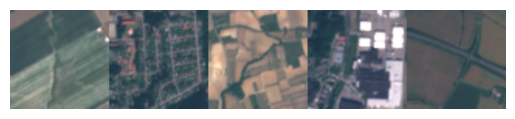

In [14]:
helpers.plotting.show_image(
    einops.rearrange(imgs_to_explain, "(b1 b2) c h w -> c (b1 h) (b2 w)", b2=len(idxs_to_explain)))

[tensor(0), tensor(7), tensor(6), tensor(4), tensor(3)]


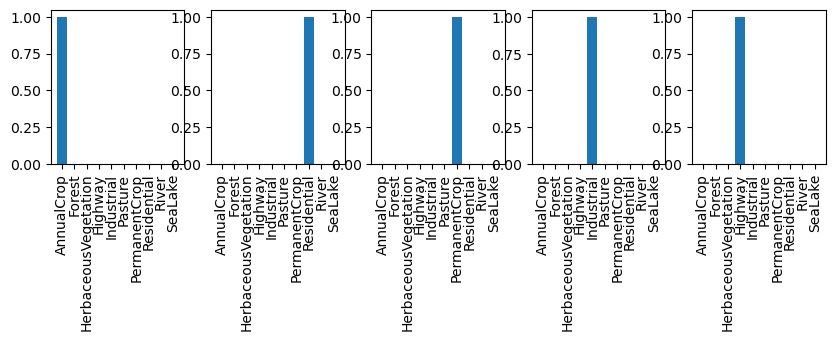

In [15]:
preds = resnet50(imgs_to_explain)
preds = torch.softmax(preds, dim=-1).cpu().detach().numpy()
_, axs = plt.subplots(1, len(idxs_to_explain), figsize=(2 * len(idxs_to_explain), 2))
for i in range(len(idxs_to_explain)):
    ax: plt.Axes = axs[i]
    ax.bar(eurosat_val_ds.classes, preds[i])
    # rotate x ticks for axis
    ax.tick_params(axis='x', rotation=90)
print(true_labels)

In [16]:
random_bg_imgs = torch.stack([eurosat_val_ds[i]["image"] for i in np_rng.integers(0, len(eurosat_val_ds), 100)]).to(
    device)

In [17]:
random_blurred_bg_imgs = transforms.functional.gaussian_blur_image(
    random_bg_imgs, kernel_size=15, sigma=10
).to(device)

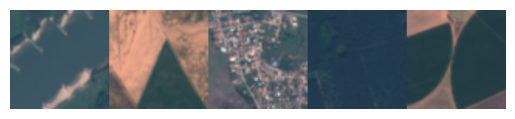

In [18]:
helpers.plotting.show_image(
    einops.rearrange(random_bg_imgs[:5], "(b1 b2) c h w -> c (b1 h) (b2 w)", b2=len(idxs_to_explain)))

### Set up/Experiment with SHAP

#### Captum DeepLiftShap

In [20]:
deep_shap_explainer = DeepLiftShap(resnet50, multiply_by_inputs=True)  # True for global attribution

In [21]:
captum_shap_vals = helpers.xai.calculate_shap_values_tensor(imgs_to_explain, blurred_imgs, deep_shap_explainer,
                                                            num_eurosat_classes)

Calculating SHAP values for class i:   0%|          | 0/10 [00:00<?, ?it/s]

/home2/jgcw74/miniconda3/envs/sat_project/lib/python3.9/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


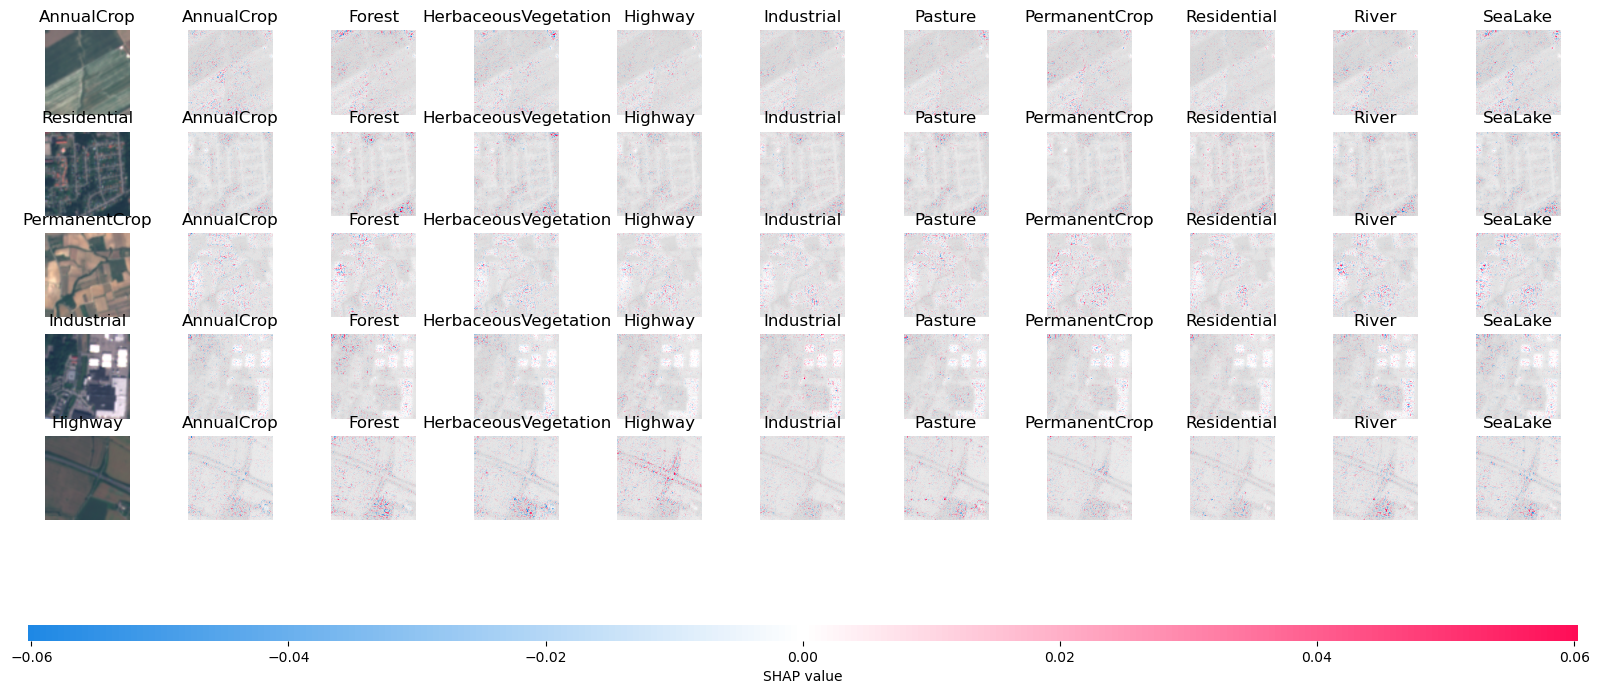

In [22]:
n = 5
shap.image_plot(
    helpers.xai.prepare_shap_for_image_plot(captum_shap_vals[:, :n]),
    einops.rearrange((imgs_to_explain[:n] + 1) / 2, "b c h w -> b h w c").cpu().numpy(),
    labels=np.tile(eurosat_val_ds.classes, (imgs_to_explain[:n].shape[0], 1)),
    true_labels=[eurosat_val_ds.classes[int(i)] for i in true_labels[:n]],
)

##### Pooled SHAP values

In [23]:
pool_size = 16
pooled_captum_shap_vals = (pool_size ** 2) * nn.AvgPool2d(kernel_size=pool_size, stride=pool_size)(
    captum_shap_vals.flatten(0, 1)
).repeat_interleave(pool_size, dim=-2).repeat_interleave(pool_size, dim=-1)
pooled_captum_shap_vals = torch.unflatten(pooled_captum_shap_vals, 0, (num_eurosat_classes, -1))

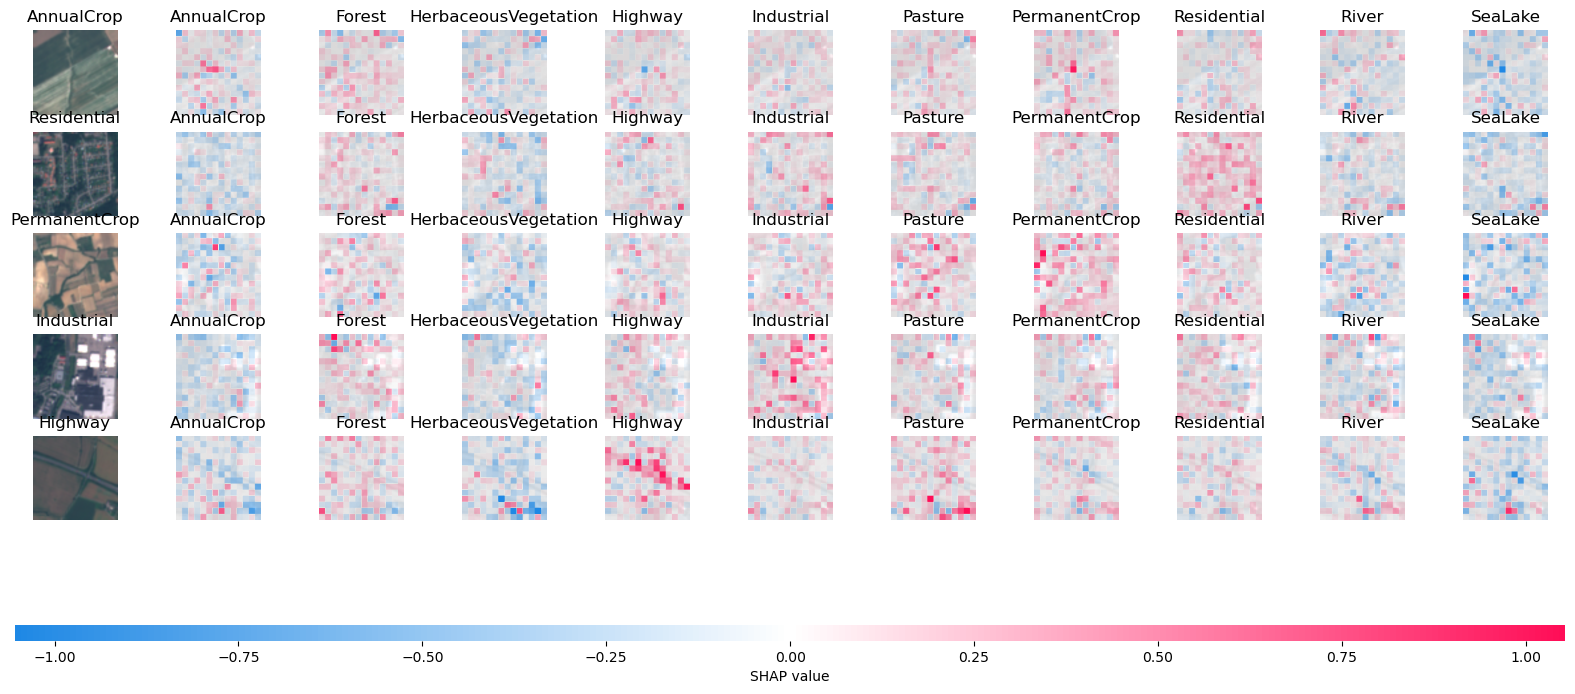

In [24]:
n = 5
shap.image_plot(
    helpers.xai.prepare_shap_for_image_plot(pooled_captum_shap_vals[:, :n]),
    einops.rearrange((imgs_to_explain[:n] + 1) / 2, "b c h w -> b h w c").cpu().numpy(),
    labels=np.tile(eurosat_val_ds.classes, (imgs_to_explain[:n].shape[0], 1)),
    true_labels=[eurosat_val_ds.classes[int(i)] for i in true_labels[:n]],
)

Calculating SHAP values for class i:   0%|          | 0/10 [00:00<?, ?it/s]

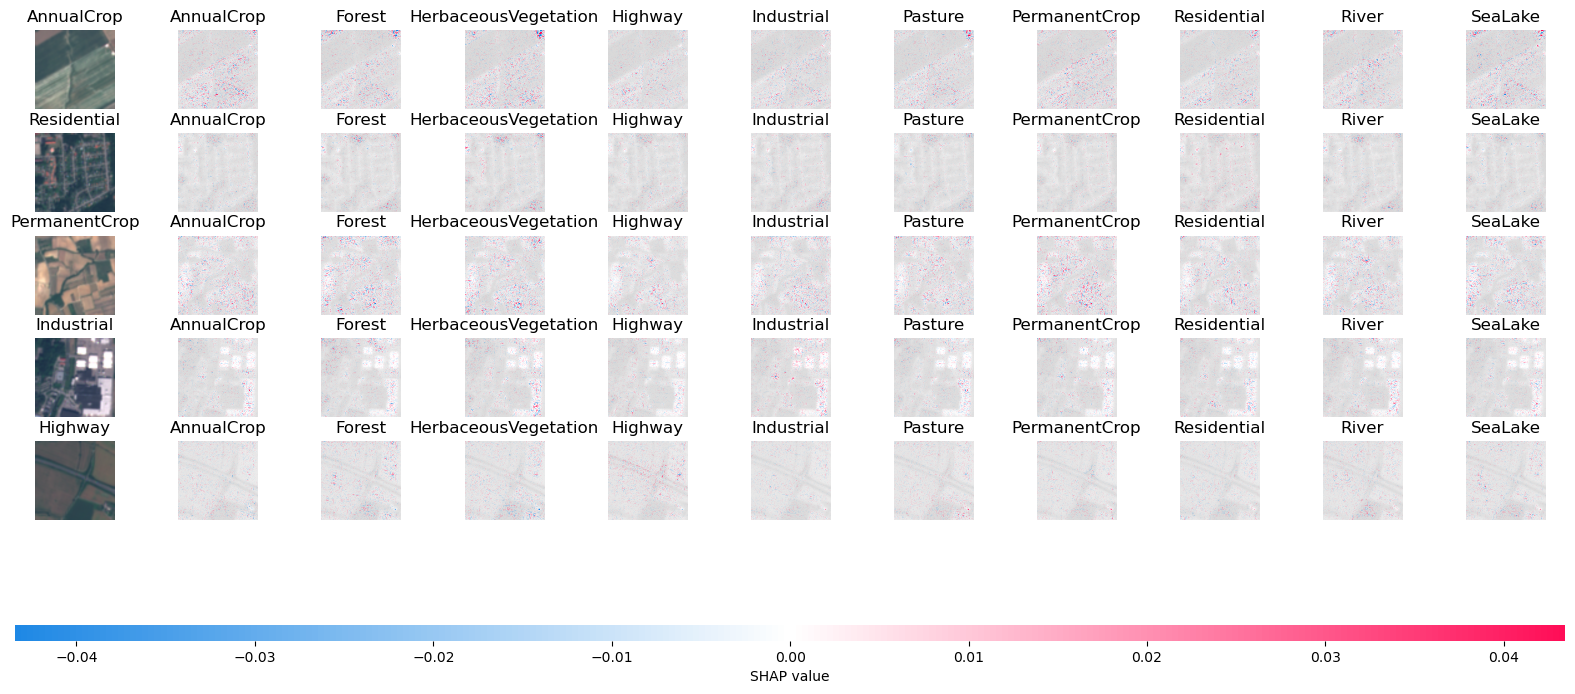

In [25]:
captum_random_bg_shap_vals = helpers.xai.calculate_shap_values_tensor(imgs_to_explain, random_bg_imgs[:25],
                                                                      deep_shap_explainer, num_eurosat_classes)

n = 5
shap.image_plot(
    helpers.xai.prepare_shap_for_image_plot(captum_random_bg_shap_vals[:, :n]),
    einops.rearrange((imgs_to_explain[:n] + 1) / 2, "b c h w -> b h w c").cpu().numpy(),
    labels=np.tile(eurosat_val_ds.classes, (imgs_to_explain[:n].shape[0], 1)),
    true_labels=[eurosat_val_ds.classes[int(i)] for i in true_labels[:n]],
    hspace=0.3,
)

#### Original SHAP library

In [26]:
def predict_fn(np_imgs: np.ndarray):
    model_input_img = einops.rearrange(torch.from_numpy(np_imgs * 2) - 1, "b h w c -> b c h w").to(device)
    model_output: torch.Tensor = resnet50(model_input_img)
    # softmax_output = torch.softmax(model_output, dim=-1)
    return model_output.cpu().detach().numpy()

In [27]:
np01_imgs_to_explain = einops.rearrange((imgs_to_explain + 1) / 2, "b c h w -> b h w c").cpu().numpy()

##### Partition Explainer

Following regime in https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/Explain%20MobilenetV2%20using%20the%20Partition%20explainer%20%28PyTorch%29.html

In [28]:
blur_masker = shap.maskers.Image("blur(128,128)", np01_imgs_to_explain[0].shape)
partition_explainer = shap.PartitionExplainer(predict_fn, blur_masker, output_names=eurosat_val_ds.classes)

In [29]:
partition_shap_vals = partition_explainer(
    np01_imgs_to_explain,
    max_evals=10000,
    batch_size=128,
    outputs=shap.Explanation.argsort.flip,  # order from most confident prediction (left) to lowest
)

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 1/5 [00:00<?, ?it/s]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 3/5 [01:14<00:36, 18.05s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 4/5 [01:50<00:25, 25.53s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 5/5 [02:27<00:00, 29.53s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 6it [03:03, 36.68s/it]                       


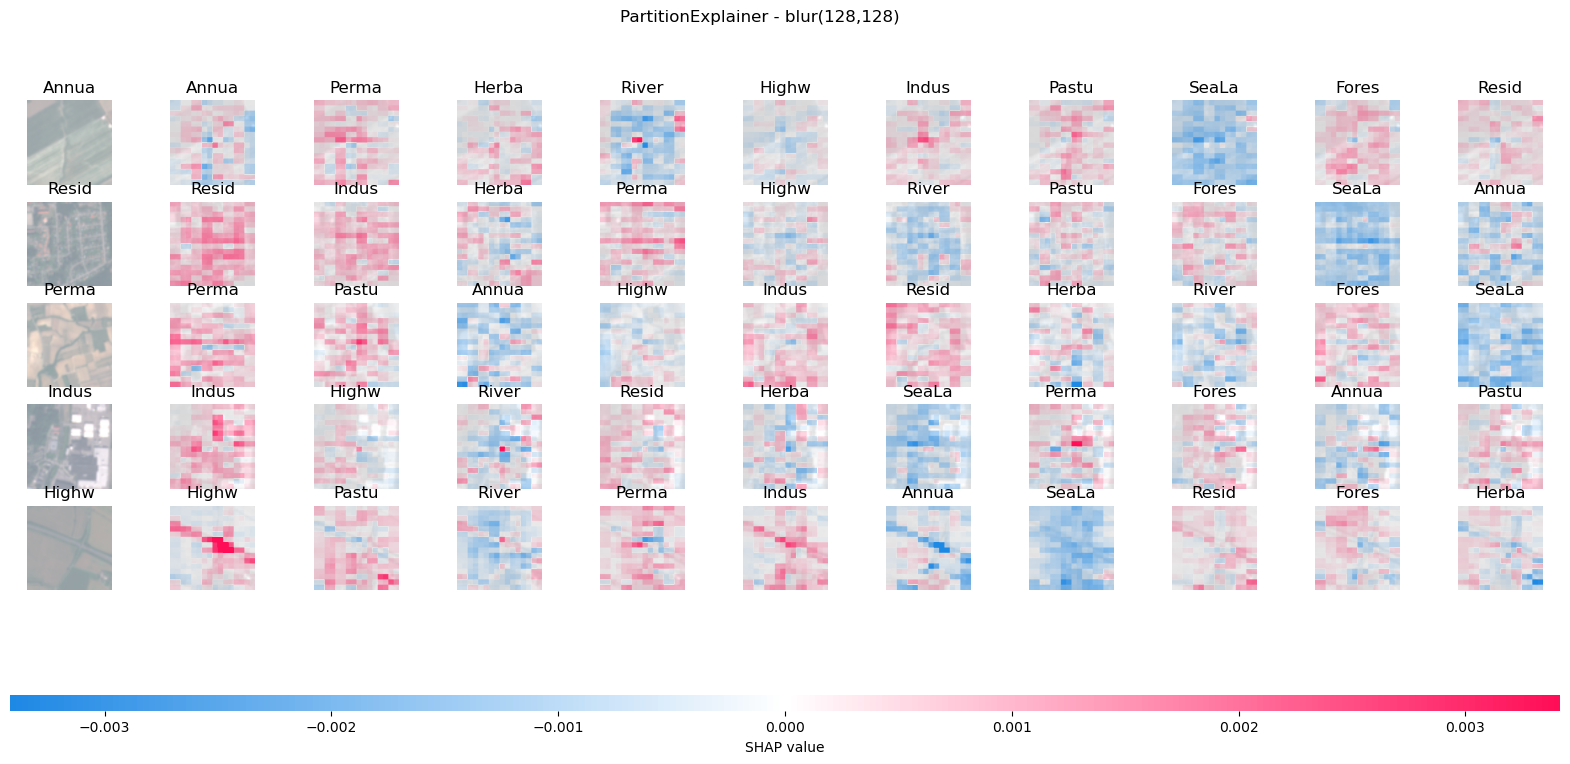

In [30]:
shap.image_plot(
    shap_values=[val for val in np.moveaxis(partition_shap_vals.values, -1, 0)],
    pixel_values=((partition_shap_vals.data + 1) / 2),
    labels=np.vectorize(lambda x: x[:5])(partition_shap_vals.output_names),
    true_labels=[f'{eurosat_val_ds.classes[int(i)][:5]}' for i in true_labels],
    show=False,
)
_ = plt.gcf().suptitle(f"{partition_explainer.__class__.__name__} - {blur_masker.mask_value}")

###### Using 0 masker

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:53, 26.80s/it]               


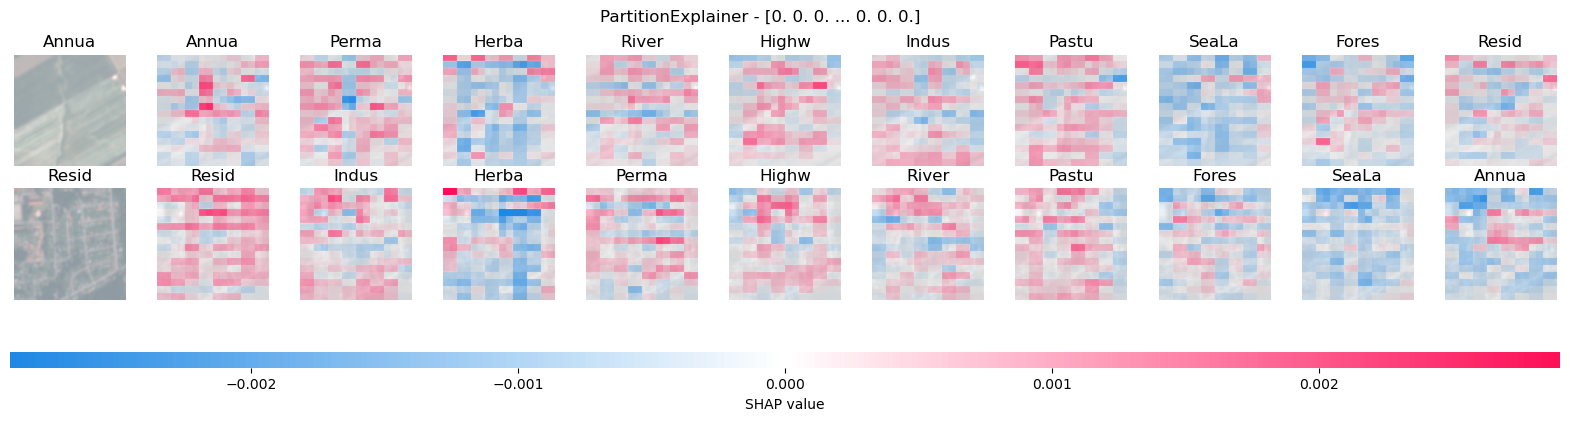

In [31]:
masker = shap.maskers.Image(0, np01_imgs_to_explain[0].shape)  # fill with zeros rather than blurring
partition0_explainer = shap.PartitionExplainer(predict_fn, masker, output_names=eurosat_val_ds.classes)
partition0_shap_vals = partition0_explainer(
    np01_imgs_to_explain[:2],
    max_evals=10000,
    batch_size=128,
    outputs=shap.Explanation.argsort.flip,  # order from most confident prediction (left) to lowest
)
shap.image_plot(
    shap_values=[val for val in np.moveaxis(partition0_shap_vals.values, -1, 0)],
    pixel_values=((partition0_shap_vals.data + 1) / 2),
    labels=np.vectorize(lambda x: x[:5])(partition0_shap_vals.output_names),
    true_labels=[f'{eurosat_val_ds.classes[int(i)][:5]}' for i in true_labels[:2]],
    show=False,
)
_ = plt.gcf().suptitle(f"{partition_explainer.__class__.__name__} - {masker.mask_value}")

##### Deep Explainer (broken?)

Following regime in https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/PyTorch%20Deep%20Explainer%20MNIST%20example.html

In [32]:
deep_explainer = shap.DeepExplainer(resnet50, random_bg_imgs[:50])

Requires a lot of GPU memory - 50 background images requires 17.3GB of GPU memory/VRAM

In [33]:
# additivity check fails - implementation bug on my or shap's end...?
deep_shap_vals = deep_explainer.shap_values(imgs_to_explain[:2], check_additivity=False)
deep_shap_vals = einops.rearrange(deep_shap_vals, "b c h w l -> l b c h w")

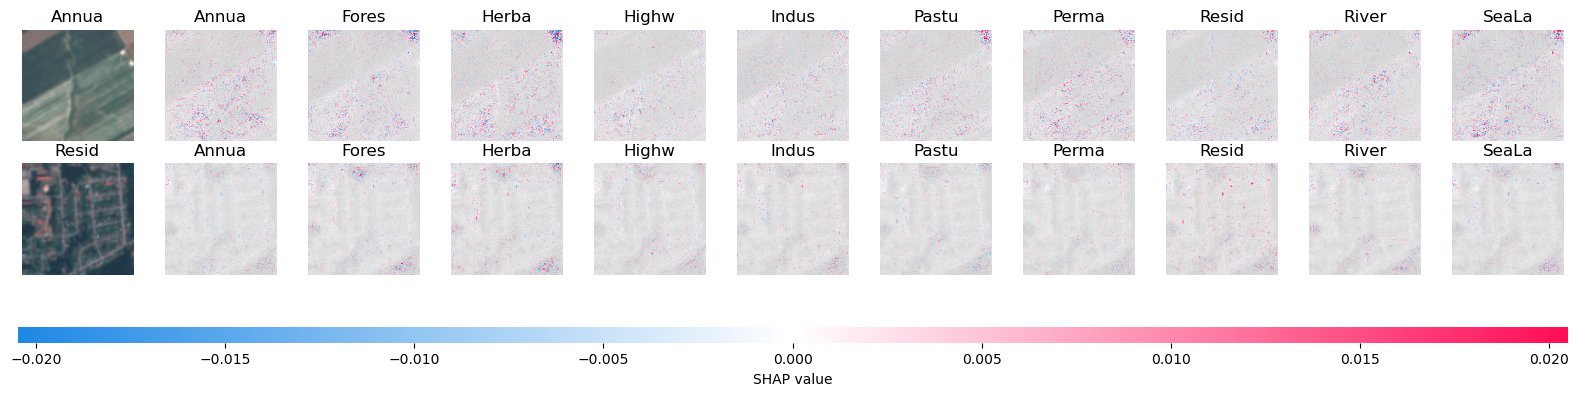

In [34]:
shap.image_plot(
    list(einops.rearrange(deep_shap_vals, "l b c h w -> l b h w c")),
    pixel_values=einops.rearrange((imgs_to_explain[:2] + 1) / 2, "b c h w -> b h w c").cpu().numpy(),
    labels=(np.tile([x[:5] for x in eurosat_val_ds.classes], (imgs_to_explain[:2].shape[0], 1))),
    true_labels=[f'{eurosat_val_ds.classes[int(i)][:5]}' for i in true_labels[:2]],
    show=True,
)

In [35]:
pool_size = 16
pooled_deep_shap_vals = (pool_size ** 2) * nn.AvgPool2d(kernel_size=pool_size, stride=pool_size)(
    torch.from_numpy(deep_shap_vals).flatten(0, 1)).repeat_interleave(pool_size, dim=-2).repeat_interleave(pool_size,
                                                                                                           dim=-1)
pooled_deep_shap_vals = torch.unflatten(pooled_deep_shap_vals, 0, (num_eurosat_classes, -1))

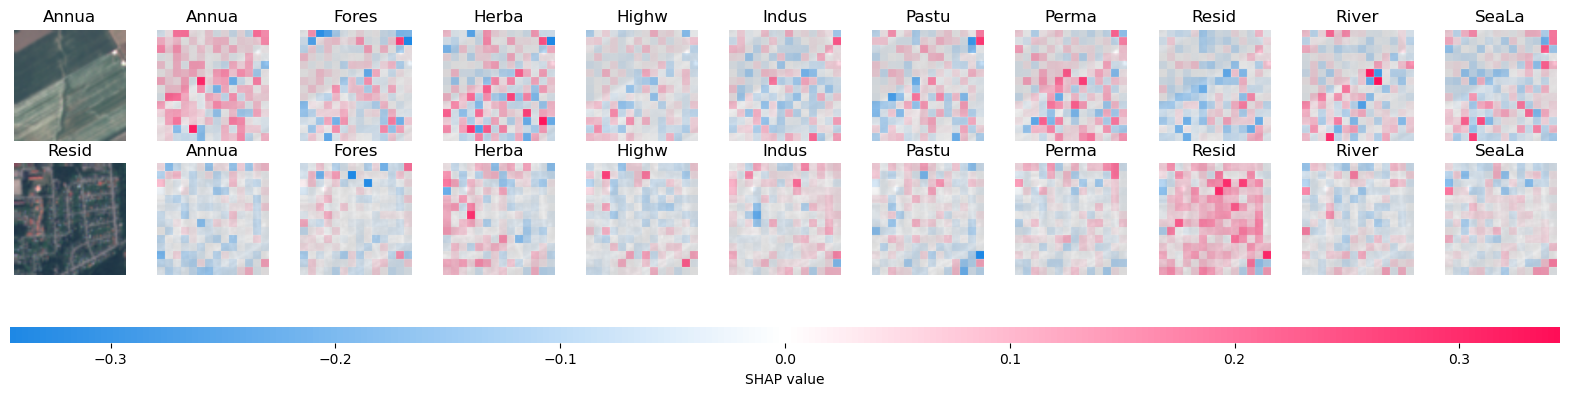

In [36]:
shap.image_plot(
    list(einops.rearrange(pooled_deep_shap_vals, "l b c h w -> l b h w c")),
    pixel_values=einops.rearrange((imgs_to_explain[:2] + 1) / 2, "b c h w -> b h w c").cpu().numpy(),
    labels=(np.tile([x[:5] for x in eurosat_val_ds.classes], (imgs_to_explain[:2].shape[0], 1))),
    true_labels=[f'{eurosat_val_ds.classes[int(i)][:5]}' for i in true_labels[:2]],
    show=True,
)

###### Trying to debug the additivity of DeepExplainer...

In [37]:
class ResNet50Wrapper(nn.Module):
    def __init__(self, model: nn.Module):
        super().__init__()
        self.model = model.eval()
        self.output = nn.Softmax(dim=-1)

    def forward(self, x):
        return self.output(self.model(x))


wrapped_resnet50 = ResNet50Wrapper(resnet50)

In [39]:
e = shap.DeepExplainer(wrapped_resnet50, random_bg_imgs[:50])
# s = e.shap_values(imgs_to_explain[:2], check_additivity=True)

In [40]:
imgs_to_explain.min(), imgs_to_explain.max(), random_bg_imgs.min(), random_bg_imgs.max()

(tensor(-0.7895, device='cuda:0'),
 tensor(1., device='cuda:0'),
 tensor(-0.8266, device='cuda:0'),
 tensor(1., device='cuda:0'))

In [41]:
# Use a simpler model for testing
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(16 * 224 * 224, num_eurosat_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


simple_model = SimpleModel().to(device)

e = shap.DeepExplainer(simple_model, random_bg_imgs[:50])
# s = e.shap_values(imgs_to_explain[:2], check_additivity=True)

### Evaluate SHAP

In [19]:
randomised_model = copy.deepcopy(resnet50).to(device)
helpers.evaluate_xai.reset_child_params(randomised_model)
_ = randomised_model.eval()

In [20]:
if check_acc:
    _, og_acc = helpers.ml.validation_step(
        resnet50, nn.CrossEntropyLoss(), validation_iterator, len(val_dataloader)
    )
    _, random_acc = helpers.ml.validation_step(
        randomised_model, nn.CrossEntropyLoss(), validation_iterator, len(val_dataloader)
    )
    print(f"Original/Randomised accuracy on validation set: {og_acc:.4f}/{random_acc:.4f}")

##### Calculate Final Values

###### Calculate Captum SHAP values

Requires ~18GB of GPU memory (VRAM)

In [30]:
og_shap_e = DeepLiftShap(resnet50, multiply_by_inputs=True)
random_shap_e = DeepLiftShap(randomised_model, multiply_by_inputs=True)

In [56]:
og_shap_values = helpers.xai.calculate_shap_values_tensor(imgs_to_explain, blurred_imgs, og_shap_e, num_eurosat_classes)
random_shap_values = helpers.xai.calculate_shap_values_tensor(imgs_to_explain, blurred_imgs, random_shap_e,
                                                              num_eurosat_classes)

Calculating SHAP values for class i:   0%|          | 0/10 [00:00<?, ?it/s]

/home2/jgcw74/miniconda3/envs/sat_project/lib/python3.9/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


Calculating SHAP values for class i:   0%|          | 0/10 [00:00<?, ?it/s]

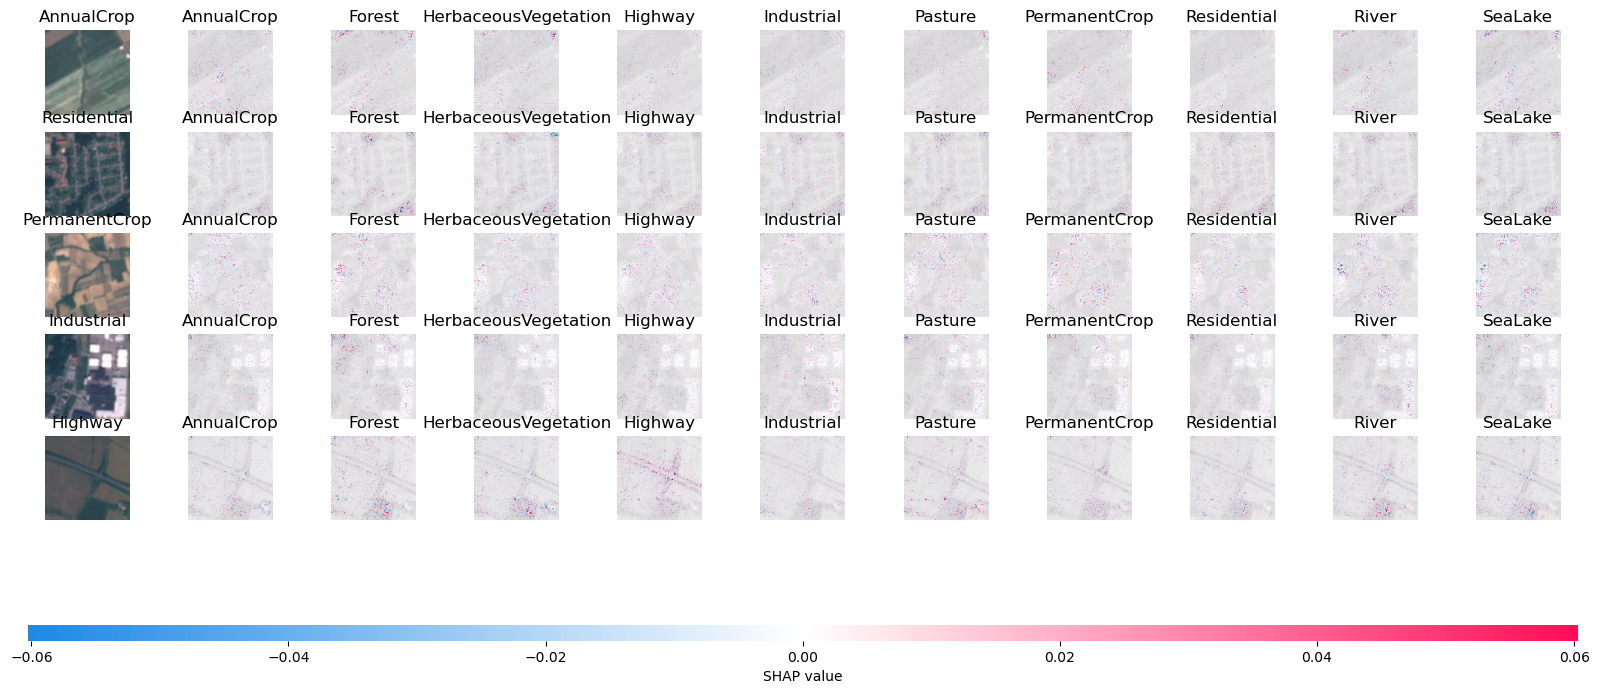

In [33]:
n = 5
shap.image_plot(
    helpers.xai.prepare_shap_for_image_plot(og_shap_values[:, :n]),
    einops.rearrange((imgs_to_explain[:n] + 1) / 2, "b c h w -> b h w c").cpu().numpy(),
    labels=np.tile(eurosat_val_ds.classes, (imgs_to_explain[:n].shape[0], 1)),
    true_labels=[eurosat_val_ds.classes[int(i)] for i in true_labels[:n]],
)

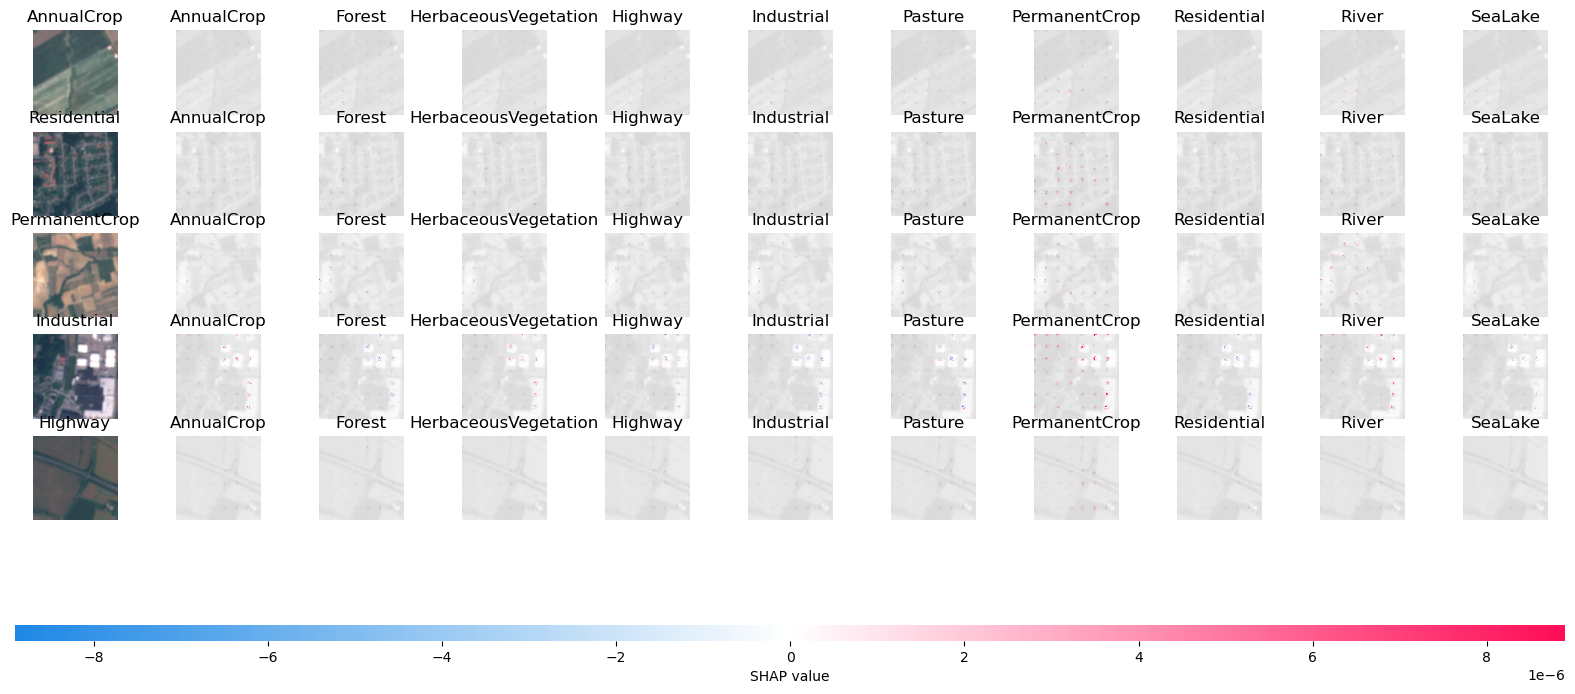

In [34]:
n = 5
shap.image_plot(
    helpers.xai.prepare_shap_for_image_plot(random_shap_values[:, :n]),
    einops.rearrange((imgs_to_explain[:n] + 1) / 2, "b c h w -> b h w c").cpu().numpy(),
    labels=np.tile(eurosat_val_ds.classes, (imgs_to_explain[:n].shape[0], 1)),
    true_labels=[eurosat_val_ds.classes[int(i)] for i in true_labels[:n]],
)

###### Calculate Partition SHAP values


In [35]:
from functools import partial

In [36]:
np01_imgs_to_explain = einops.rearrange((imgs_to_explain + 1) / 2, "b c h w -> b h w c").cpu().numpy()

In [37]:
def predict_fn(np_imgs: np.ndarray, model: nn.Module = None):
    model_input_img = einops.rearrange(torch.from_numpy(np_imgs * 2) - 1, "b h w c -> b c h w").to(device)
    model_output: torch.Tensor = model(model_input_img)
    # softmax_output = torch.softmax(model_output, dim=-1)
    return model_output.cpu().detach().numpy()

In [38]:
blur_masker = shap.maskers.Image("blur(128,128)", np01_imgs_to_explain[0].shape)
og_partition_e = shap.PartitionExplainer(partial(predict_fn, model=resnet50), blur_masker,
                                         output_names=eurosat_val_ds.classes)
random_partition_e = shap.PartitionExplainer(partial(predict_fn, model=randomised_model), blur_masker,
                                             output_names=eurosat_val_ds.classes)

In [51]:
partition_og_shap = og_partition_e(
    np01_imgs_to_explain,
    max_evals=10000,
    batch_size=128,
    # outputs=shap.Explanation.argsort.flip,  # order from most confident prediction (left) to lowest
)
partition_random_shap = random_partition_e(
    np01_imgs_to_explain,
    max_evals=10000,
    batch_size=128,
    # outputs=shap.Explanation.argsort.flip,  # order from most confident prediction (left) to lowest
)

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 1/5 [00:00<?, ?it/s]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 3/5 [01:02<00:31, 15.65s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 4/5 [01:34<00:22, 22.25s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 5/5 [02:05<00:00, 25.77s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 6it [02:37, 31.54s/it]                       


  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|██        | 1/5 [00:00<?, ?it/s]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 3/5 [01:03<00:31, 15.90s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 4/5 [01:35<00:22, 22.55s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 5/5 [02:07<00:00, 26.04s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 6it [02:38, 31.80s/it]                       


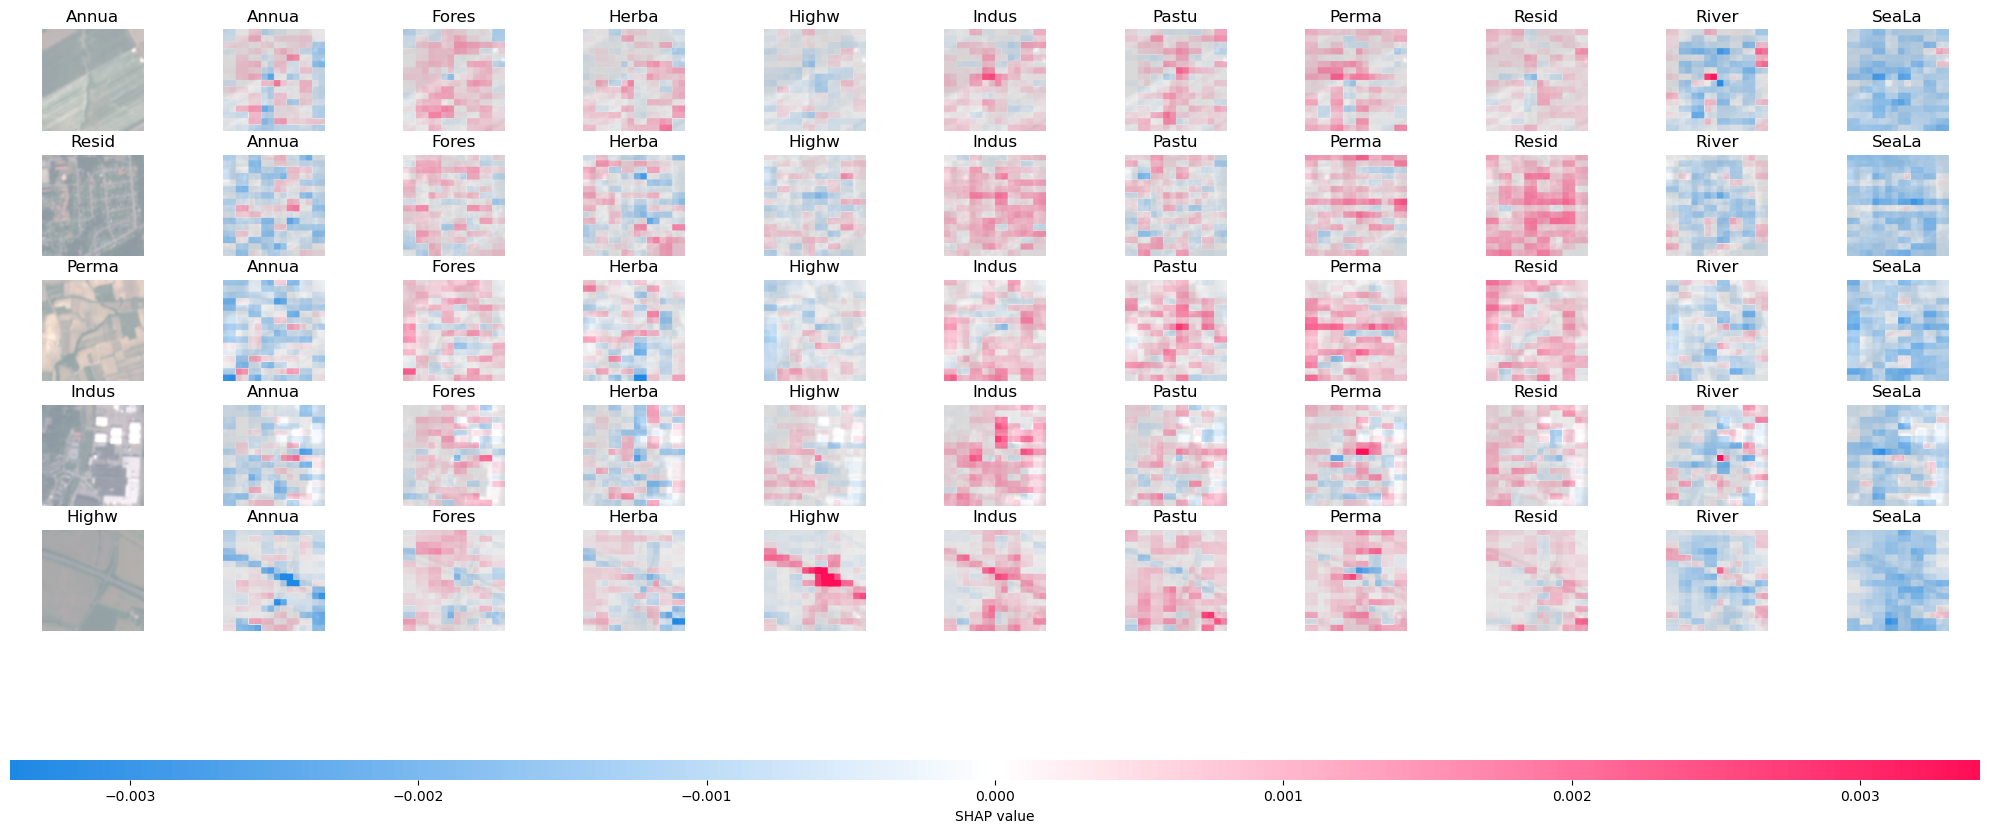

In [52]:
shap.image_plot(
    shap_values=[val for val in np.moveaxis(partition_og_shap.values, -1, 0)],
    pixel_values=((partition_og_shap.data + 1) / 2),
    labels=np.tile([x[:5] for x in eurosat_val_ds.classes], (imgs_to_explain.shape[0], 1)),
    true_labels=[f'{eurosat_val_ds.classes[int(i)][:5]}' for i in true_labels],
    hspace="auto",
    show=False,
)
# _ = plt.gcf().suptitle(f"{og_partition_e.__class__.__name__} - {blur_masker.mask_value}")

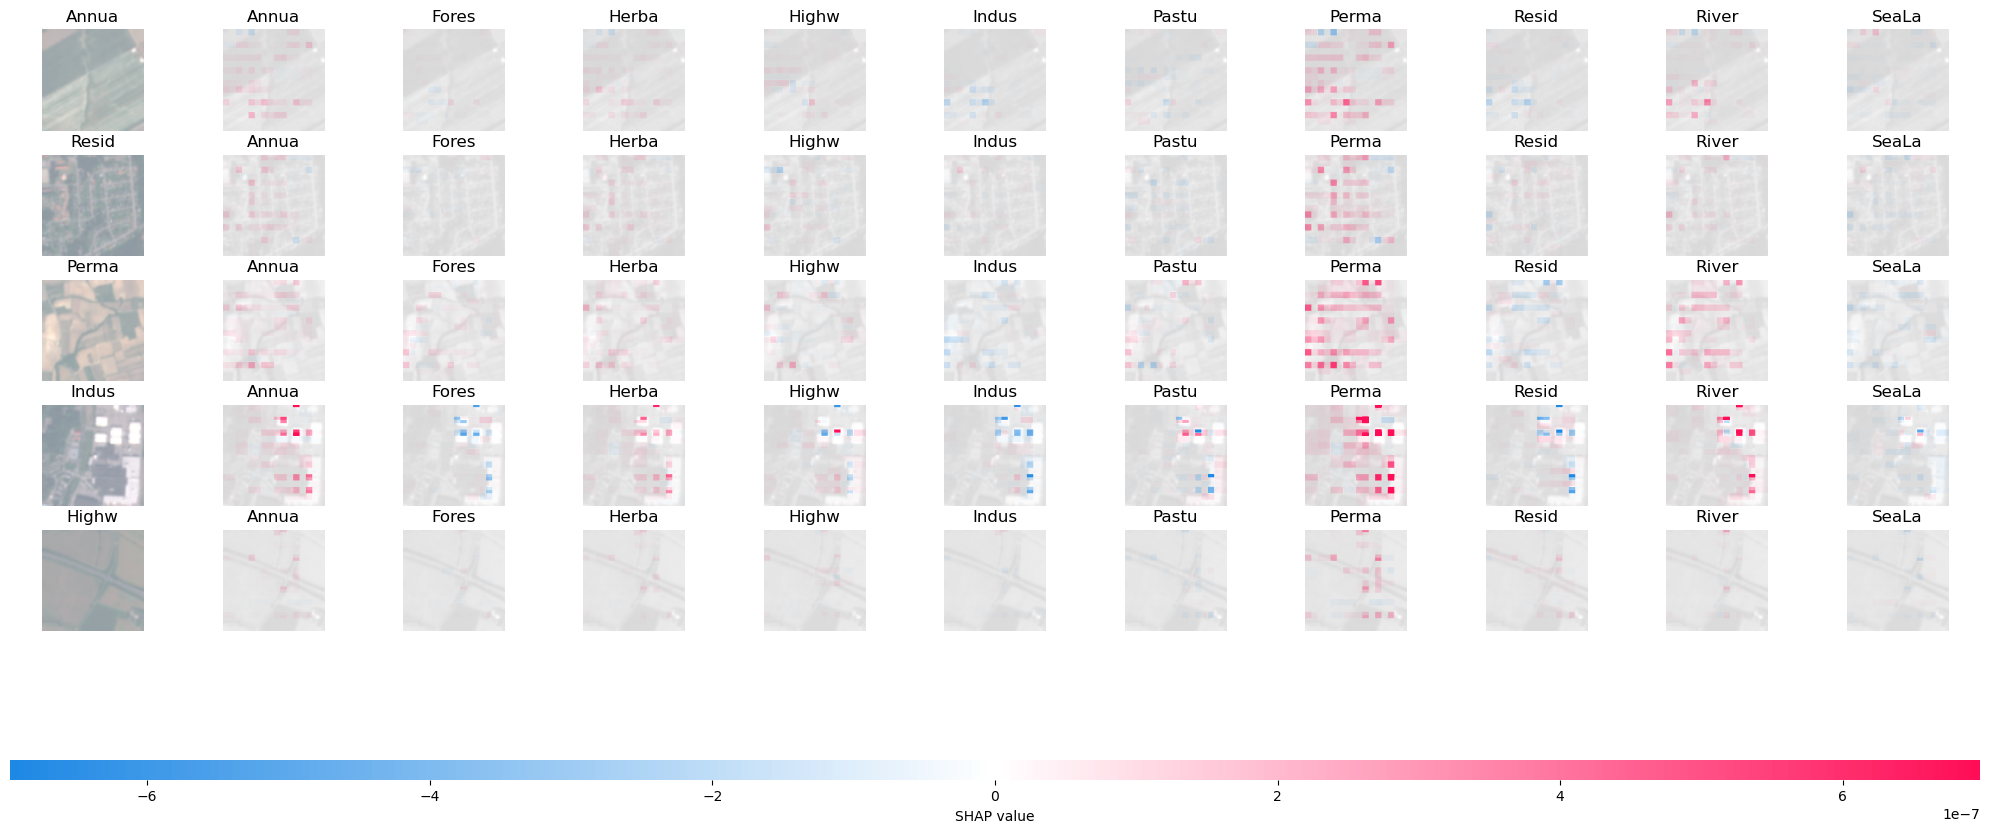

In [53]:
shap.image_plot(
    shap_values=[val for val in np.moveaxis(partition_random_shap.values, -1, 0)],
    pixel_values=((partition_random_shap.data + 1) / 2),
    labels=np.tile([x[:5] for x in eurosat_val_ds.classes], (imgs_to_explain.shape[0], 1)),
    true_labels=[f'{eurosat_val_ds.classes[int(i)][:5]}' for i in true_labels],
    hspace="auto",
    show=False,
)
# _ = plt.gcf().suptitle(f"{random_partition_e.__class__.__name__} - {blur_masker.mask_value}")

#### Save/Load SHAP values

In [21]:
output_path = Path.cwd() / "output"

In [22]:
# np.savez(output_path / "resnet50_shap_vals.npz",
#          og_shap_values=og_shap_values.cpu(),
#          random_shap_values=random_shap_values.cpu(),
#          partition_og_shap_values=partition_og_shap.values,
#          partition_random_shap_values=partition_random_shap.values)

In [23]:
with np.load(output_path / "resnet50_shap_vals.npz") as data:
    og_shap_values = data["og_shap_values"]
    random_shap_values = data["random_shap_values"]
    partition_og_shap_values = data["partition_og_shap_values"]
    partition_random_shap_values = data["partition_random_shap_values"]

#### Correctness: Parameter Randomisation

##### Calculate Difference (the actual evaluation)

In [24]:
print(eurosat_val_ds.classes)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [25]:
# partition_og_shap_values.values.shape, np.array(helpers.xai.prepare_shap_for_image_plot(og_shap_values)).transpose(1, 0, 2, 3, 4).shape

In [26]:
s1 = np.array(helpers.xai.prepare_shap_for_image_plot(og_shap_values)).transpose(1, 0, 2, 3, 4)
s2 = np.array(helpers.xai.prepare_shap_for_image_plot(random_shap_values)).transpose(1, 0, 2, 3, 4)
print(s1.shape)
helpers.evaluate_xai.pixel_l2_distance_per_label(s1, s2)

(5, 10, 224, 224, 3)


tensor([0.0029, 0.0031, 0.0029, 0.0030, 0.0030, 0.0030, 0.0030, 0.0029, 0.0030,
        0.0029])

In [27]:
s1 = einops.rearrange(partition_og_shap_values, "b h w c l -> b l h w c")
s2 = einops.rearrange(partition_random_shap_values, "b h w c l -> b l h w c")

l2_df = helpers.evaluate_xai.make_l2_distance_per_label_df(eurosat_val_ds.classes, s1, s2, normalise=True)
l2_df

L2 distance
Class                            
AnnualCrop               0.057151
Forest                   0.084282
HerbaceousVegetation     0.071515
Highway                  0.073634
Industrial               0.096201
Pasture                  0.087057
PermanentCrop            0.087487
Residential              0.094308
River                    0.056001
SeaLake                  0.035029

<Axes: title={'center': "L2 distance between randomised and true model's shap values"}, xlabel='class', ylabel='L2 distance'>

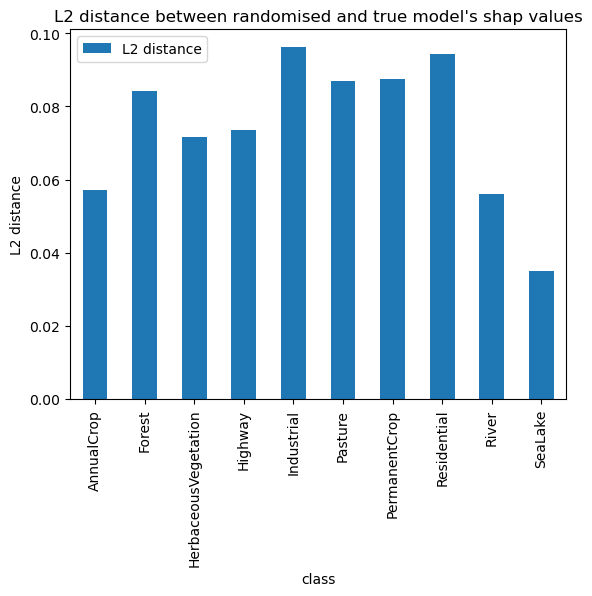

In [28]:
l2_df.plot(kind="bar", xlabel="class", ylabel="L2 distance",
           title="L2 distance between randomised and true model's shap values")

#### Correctness: Incremental Deletion

In [29]:
partition_shap_vals = einops.rearrange(partition_og_shap_values, "b h w c l -> b l h w c")
partition_shap_vals.shape

(5, 10, 224, 224, 3)

In [30]:
shap_importance_rank = helpers.evaluate_xai.rank_pixel_importance(partition_shap_vals)

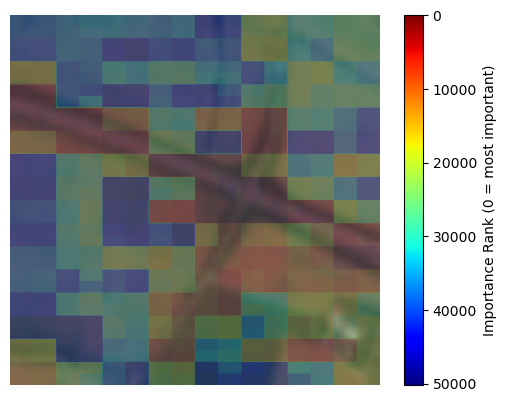

In [31]:
i = 4  # selected image for testing
true_label_text = eurosat_val_ds.classes[int(true_labels[i])]
helpers.plotting.visualise_importance(
    imgs_to_explain[i], shap_importance_rank[i][int(true_labels[i])]
)
plt.show()

##### Deletion/Infilling

###### By importance

Incrementally deleting important pixels:   0%|          | 0/31 [00:00<?, ?it/s]

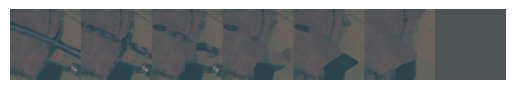

In [229]:
num_del_iterations = 30
iterative_deletions, k_values = helpers.evaluate_xai.incrementally_delete(imgs_to_explain[i].cpu().numpy(),
                                                                          shap_importance_rank[i][int(true_labels[i])],
                                                                          num_del_iterations,
                                                                          "nn")  # Nearest neighbour deletion as in I. Kakogeorgiou and K. Karantzalos
iterative_deletions = np.squeeze(
    iterative_deletions)  # remove singleton dim (there is only 1 trial when importance_rank is specified)
helpers.plotting.show_image(einops.rearrange(iterative_deletions[::5], "p c h w -> c h (p w)"))
plt.show()
# helpers.plotting.show_image(einops.rearrange(iterative_deletions[-3:], "p c h w -> c h (p w)"))
# plt.show()

In [230]:
df = helpers.evaluate_xai.make_preds_df(resnet50, iterative_deletions, columns=eurosat_val_ds.classes, max_batch_size=4)

<Axes: title={'center': 'Effect of deletions on correct class prediction confidence'}, xlabel='iterations', ylabel='confidence'>

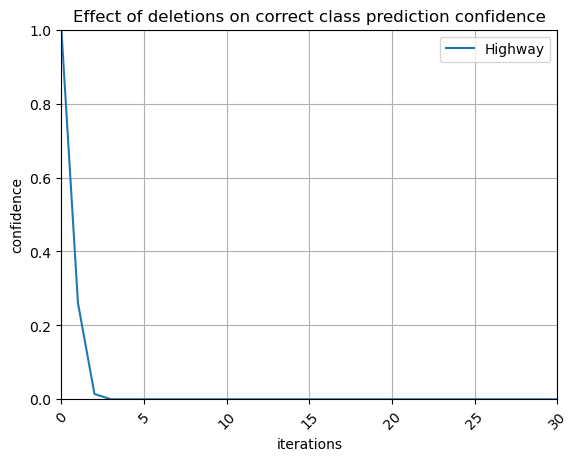

In [231]:
# df.plot(kind="bar", stacked=False, grid=True, rot=45, figsize=(15, 5),
#         title="Change in predictions with incremental deletion")
df.plot(kind="line", xlabel="iterations", rot=45, xlim=(0, num_del_iterations),
        y=true_label_text,
        ylabel="confidence", ylim=(0, 1),
        grid=True,
        title="Effect of deletions on correct class prediction confidence")

###### Randomised

Incrementally deleting important pixels:   0%|          | 0/31 [00:00<?, ?it/s]

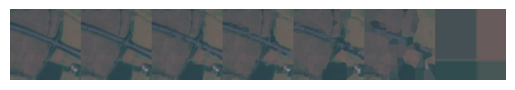

In [232]:
num_rand_trials = 10
random_deletions, k_values = helpers.evaluate_xai.incrementally_delete(imgs_to_explain[i].cpu().numpy(),
                                                                       (16, None, num_rand_trials),
                                                                       num_del_iterations, "nn")

helpers.plotting.show_image(einops.rearrange(random_deletions[::5, 0], "p c h w -> c h (p w)"))

In [233]:
flatted_random_deletions = random_deletions.reshape(-1, *random_deletions.shape[2:])  # combine iterations and trials
flatted_random_deletions.shape

(310, 3, 224, 224)

In [234]:
rand_df = helpers.evaluate_xai.make_preds_df(resnet50, flatted_random_deletions, columns=eurosat_val_ds.classes,
                                             max_batch_size=5)
rand_df = rand_df.groupby(np.arange(len(rand_df)) // num_rand_trials).mean()

##### Area under curve calculation

{'cam': 0.7752138, 'random': 11.121548}

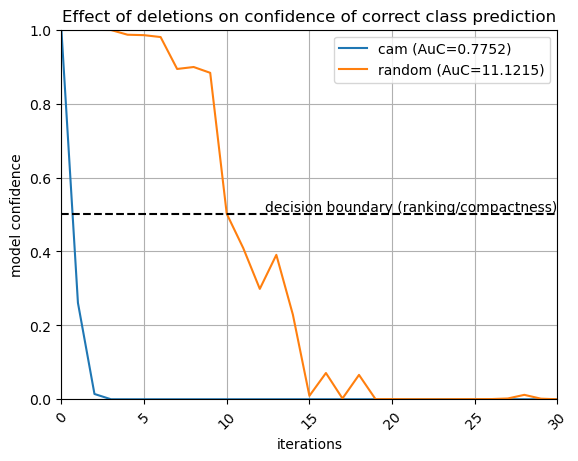

In [235]:
importlib.reload(helpers.plotting)
helpers.plotting.make_deletions_plot(df, rand_df, return_aucs=True,
                                     method_names=["cam", "random"], plot_class=true_label_text,
                                     plt_title="Effect of deletions on confidence of correct class prediction")

#### Output-completeness
Preservation/Deletion check

In [158]:
deletion_threshold = 0.1  # "All important features"
img = imgs_to_explain[i].cpu().numpy()
num_pixels = img.shape[-2] * img.shape[-1]

##### Deletion

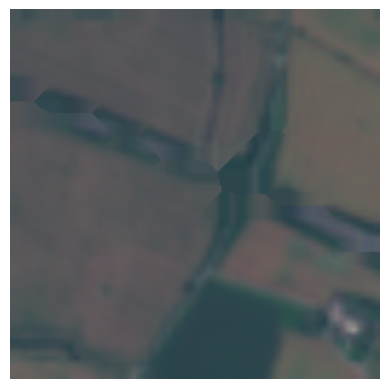

In [178]:
deleted = helpers.evaluate_xai.delete_top_k_important(img, shap_importance_rank[i][int(true_labels[i])],
                                                      deletion_threshold * num_pixels, "nn")
helpers.plotting.show_image(deleted)

In [179]:
random_deleted_images = []
for _ in range(num_rand_trials):
    random_deleted_images.append(
        helpers.evaluate_xai.delete_top_k_important(img, (16, np_rng), deletion_threshold * num_pixels, "nn")
    )
random_deleted_images = np.array(random_deleted_images)
# helpers.plotting.show_image(deleted)

In [180]:
random_deletion_check_df = helpers.evaluate_xai.make_preds_df(
    resnet50, random_deleted_images, columns=eurosat_val_ds.classes, max_batch_size=5
)
random_deletion_acc = random_deletion_check_df[true_label_text].mean()
random_deletion_acc

0.9954252

In [181]:
org_acc, del_acc = resnet50(
    torch.from_numpy(np.stack([img, deleted])).to(device)
).detach().cpu().softmax(-1)[:, int(true_labels[i])]
org_acc, del_acc

(tensor(1.0000), tensor(8.4842e-06))

In [182]:
# drop in acc vs random = (rand_del_acc - org_acc) - (del_acc - org_acc) = rand_del_acc - del_acc
print("Deletion check (↑, 1 best):",
      random_deletion_acc - del_acc.item())  # we want del_acc to be low for a good explanation

Deletion check (↑, 1 best): 0.9954167401465384


##### Preservation (inverse of deletion)

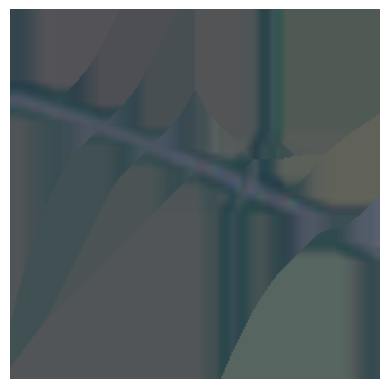

In [237]:
inverted_rank = helpers.evaluate_xai.rank_pixel_importance(
    shap_importance_rank[i][int(true_labels[i])][..., np.newaxis])  # newaxis to add expected colour channel
preserved = helpers.evaluate_xai.delete_top_k_important(img, inverted_rank, (1 - deletion_threshold) * num_pixels, "nn")
helpers.plotting.show_image(preserved)

In [187]:
random_preserved_images = []
for _ in range(num_rand_trials):
    random_preserved_images.append(
        helpers.evaluate_xai.delete_top_k_important(img, (16, np_rng), (1 - deletion_threshold) * num_pixels, "nn")
    )
random_preserved_images = np.array(random_preserved_images)
# helpers.plotting.show_image(random_preserved_images[0])

In [188]:
random_preservation_check_df = helpers.evaluate_xai.make_preds_df(
    resnet50, random_preserved_images, columns=eurosat_val_ds.classes, max_batch_size=5
)
random_preservation_acc = random_preservation_check_df[true_label_text].mean()
random_preservation_acc

0.0017651018

In [189]:
org_acc, pres_acc = resnet50(
    torch.from_numpy(np.stack([img, preserved])).to(device)
).detach().cpu().softmax(-1)[:, int(true_labels[i])]
org_acc, pres_acc

(tensor(1.0000), tensor(0.9716))

In [191]:
# drop in acc vs random = 1 + (rand_pres_acc - org_acc) - (pres_acc - org_acc) = 1 + rand_pres_acc - pres_acc
print("Preservation check (↓, 0 best):",
      1 + random_preservation_acc - pres_acc.item())  # we want pres_acc to be high for a good explanation

Preservation check (↓, 0 best): 0.030205696471966803


#### Continuity: Perturbation sensitivity